<h2> Solving FloodIt Game with A* Search </h2>

http://unixpapa.com/floodit/?sz=14&nc=6

First of all I'm going to import all the necessary modules. 
<list> 
<li>I'm using NumPy here for handling 2D arrays. It's a habit thing, becuase it is memory friendly, efficient and convenient.</li>
<li>queue module is needed for queue and priority queue's</li>
<li>using mathplotlib to draw the color matrix</li>
<li>using hashlib to hash game states</li>
<li>using time module for calcuating time needed to solve the puzzle</li>
<li>using copy module for copying numpy arrays for making new states</li>
</list>

In [1]:
import numpy as np
import queue as queue
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors
from hashlib import sha1
import time
import sys

The following line of code is used to increase max recursion depth. With the default value around 35x35 board is solvable. But if we increse this to 20000, 100x100 is easily solvable.

In [2]:
sys.setrecursionlimit(20000)

Now I'll implement the a class named <b>state</b>. The state class represents a particuler state of the game board. I've made two tables below to describe variables and functions of this class

<table style="width: 100%">
  <tr>
    <th>Variable Name</th>
    <th>Type</th>
    <th>Description</th> 
  </tr>
  <tr>
    <td>hiuristic_type</td>
    <td>integer (class variable) </td>
    <td>Stores the hiuristic type</td> 
  </tr>
  
  <tr>
    <td>board</td>
    <td>NumPy 2D array of integer</td>
    <td> Stores colors of each cell of the board, Each integer maps to a diffrent color</td> 
  </tr>
  
  <tr>
    <td>depth</td>
    <td>integer</td>
    <td>Stores the depth of the state in the search tree</td> 
  </tr>
  
  <tr>
    <td>corner</td>
    <td>NumPy array of (i, j) tuples</td>
    <td>Stores indices of the blocks of the that are in the same connected component with the upper-left block</td> 
  </tr>
  
  <tr>
    <td>hash</td>
    <td>sha1 hexdigest</td>
    <td>returns a hash value for the state. notice that we can identify a game board uniquely only with the color of the corner component and the positions of blocks of the corner component. So sha1 hash was applied on these values to get the hash.</td> 
  </tr>
  
  <tr>
    <td>comp </td>
    <td>integer</td>
    <td>Stores the number of connected componets in the game board</td> 
  </tr>
  
  <tr>
    <td>candidates</td>
    <td>set</td>
    <td>Stores a set of candidate colors for the next move. By candidate color i mean all those color upon picking which for the next move will have a positive impact on the game.These are all the colors adjucent to the corner component excluding the color of the corner component.</td> 
  </tr>
  
</table>

<table style="width: 100%">
  <tr>
    <th>Function Name</th>
    <th>Description</th> 
    <th>Return Type</th>
  </tr>
  <tr>
    <td>dfs_init(self, vis, i, j, is_corner)</td>
    <td>A dfs function to detect all the connected components in the game board. If a connected component contains the upper-left block then the dfs will also populate the corner array</td> 
    <td>void</td>
  </tr>
  <tr>
    <td>dfs_candidates(self, vis, i, j)</td>
    <td>A dfs function to populate the candidates set of the current state.</td> 
    <td>void</td>
  </tr>
  <tr>
    <td>is_terminal_state(self)</td>
    <td>checks wheater all the cell of the board has same color or not</td> 
    <td>boolean</td>
  </tr>
  <tr>
    <td>change_color(self, new_color)</td>
    <td>changes the color of the corner component and increases its size accordingly. This mimics a game move and returns </td> 
    <td>state</td>
  </tr>
  <tr>
    <td>candidates_list(self)</td>
    <td>returns a set of colors that are adjucent to the conder component. excludes the color of the corner component</td> 
    <td>set</td>
  </tr> 
  <tr>
    <td>get_image(self)</td>
    <td>shows the state as an image form</td> 
    <td>void</td>
  </tr>
  <tr>
    <td>get_hash(self)</td>
    <td>return hash of the state</td> 
    <td>sha1 hexdigest</td>
  </tr>
  
  <tr>
    <td>get_depth(self)</td>
    <td>returns depth of the state in the dfs tree</td> 
    <td>int</td>
  </tr>
  
  <tr>
    <td>huristic(self)</td>
    <td>returns hiuristic value of the state</td> 
    <td>int</td>
  </tr>
</table>

In [3]:
class state:
    hiuristic_type = 0
    
    def dfs_init(self, vis, i, j, is_corner):
        vis[i, j] = True
        if is_corner:
            self.corner =  np.concatenate((self.corner, [(i, j)]))
        n, m = self.board.shape
        if i > 0 and not vis[i-1, j] and self.board[i, j] == self.board[i-1, j]:
            self.dfs_init(vis, i-1, j, is_corner)
        if j > 0 and not vis[i, j-1] and self.board[i, j] == self.board[i, j-1]:
            self.dfs_init(vis, i, j-1, is_corner)
        if i < n-1 and not vis[i+1, j] and self.board[i, j] == self.board[i+1, j]:
            self.dfs_init(vis, i+1, j, is_corner)
        if j < m-1 and not vis[i, j+1] and self.board[i, j] == self.board[i, j+1]:
            self.dfs_init(vis, i, j+1, is_corner)
    
    def dfs_candidates(self, vis, i, j):
        vis[i, j] = True
        if self.board[i, j] != self.board[0, 0]:
            self.candidates.add(self.board[i, j])
            return
        n, m = self.board.shape
        if i > 0 and not vis[i-1, j]:
            self.dfs_candidates(vis, i-1, j)
        if j > 0 and not vis[i, j-1]:
            self.dfs_candidates(vis, i, j-1)
        if i < n-1 and not vis[i+1, j]:
            self.dfs_candidates(vis, i+1, j)
        if j < m-1 and not vis[i, j+1]:
            self.dfs_candidates(vis, i, j+1)
            
    def __init__(self, board, depth):
        self.board = board
        self.depth = depth
        self.corner = np.empty((0, 2), int)
        self.comp = 1
        
        n, m = self.board.shape
        vis = np.full((n, m), False)
        self.dfs_init(vis, 0, 0, True)
        
        self.hash = sha1(self.corner)
        self.hash.update(self.board[0, 0])
        self.hash.hexdigest()
        
        for i in range(n):
            for j in range(m):
                if not vis[i, j]:
                    self.comp += 1
                    self.dfs_init(vis, i, j, False)
    
        self.candidates = set()
        vis = np.full((n, m), False)
        self.dfs_candidates(vis, 0, 0)
        
    def is_terminal_state(self):
        return self.comp == 1
    
    def change_color(self, new_color):
        ret = self.board.copy()
        for c_ord in self.corner:
            [i, j] = c_ord
            ret[i, j] = new_color
        return state(ret, self.depth + 1)
    
    def candidates_list(self):
        return self.candidates
    
    def get_image(self):
        ranges = [0, 1, 2, 3, 4, 5, 6]
        colors = [(0.95, 0.42, 0.26, 1.0), (0.99, 0.87, 0.54, 1.0), (0.85, 0.93, 0.54, 1.0), 
                  (0.40, 0.74, 0.38, 1.0), (0.0, 0.40, 0.21, 1.0),  (0.52, 0.71, 0.21, 1.0)]
        cmap, norm = from_levels_and_colors(ranges, colors)
        plt.imshow(self.board, cmap=cmap, norm=norm)
        plt.show()
    
    def hiuristic(self):
        if state.hiuristic_type == 0:
            return self.comp

        if state.hiuristic_type == 1:
            return -2 * self.get_depth()
    
    def get_hash(self):
        return self.hash
    
    def get_depth(self):
        return self.depth
    
    def __lt__(self, other):
        return self.get_depth() + self.hiuristic() < other.get_depth() + other.hiuristic()
    
    def __eq__(self, other):
        return self.get_depth() + self.hiuristic() == other.get_depth() + other.hiuristic()


Now I'll write a function called <b>solve_a_star</b> which takes <b> board </b> and a <b> hiuristic_type </b> as arguments and returns solution to the game.

In [4]:
def solve_a_star(board, hiuristic_type):
    start = time.time()
    state_cnt = 0
    prev = {}
    state.hiuristic_type = hiuristic_type
    pq = queue.PriorityQueue()
    pq.put(board)
    state_cnt += 1
    prev[board.get_hash()]=None
    while not pq.empty():
        u = pq.get()
        if u.is_terminal_state():
            print("The initial game board was:")
            board.get_image()
            print("With hiuristic type {}, {} steps were needed to solve the game".format(hiuristic_type, u.get_depth()));
            now = u
            result = []
            for it in range(0, u.get_depth()+1):
                result.append(now)
                now = prev[now.get_hash()]
            end = time.time()
            print("Total time taken to solve was {} seconds".format(end - start));
            print("Total number of state visited is {}".format(state_cnt));
            for step in reversed(result):
                step.get_image()
            return
        for color in u.candidates_list():
            v = u.change_color(color)
            if v.get_hash() not in prev:
                prev[v.get_hash()]=u
                state_cnt += 1
                pq.put(v)   
                             

Also i've written a simple bfs function named <b>solve_bfs</b> to solve the board for comparing performance.

In [5]:
def solve_bfs(board):
    start = time.time()
    state_cnt = 0
    prev = {}
    q = queue.Queue()
    q.put(board)
    state_cnt += 1
    prev[board.get_hash()]=None
    while not q.empty():
        u = q.get()
        if u.is_terminal_state():
            print("The initial game board was:")
            board.get_image()
            print("With simple bfs, {} steps were needed to solve the game".format(u.get_depth()));
            now = u
            result = []
            for it in range(0, u.get_depth()+1):
                result.append(now)
                now = prev[now.get_hash()]
            end = time.time()
            print("Total time taken to solve was {} seconds".format(end - start));
            print("Total number of state visited is {}".format(state_cnt));
            for step in reversed(result):
                step.get_image()
            return
        for color in u.candidates_list():
            v = u.change_color(color)
            if v.get_hash() not in prev:
                prev[v.get_hash()]=u
                state_cnt += 1
                q.put(v) 
               

All things done. Now lets generate random game boards and solve it.

The initial game board was:


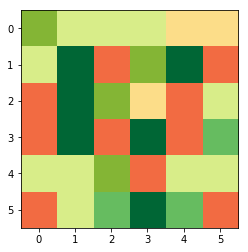

With simple bfs, 9 steps were needed to solve the game
Total time taken to solve was 49.010735750198364 seconds
Total number of state visited is 150358


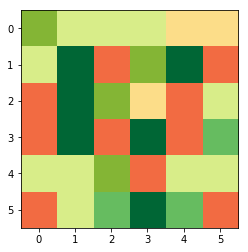

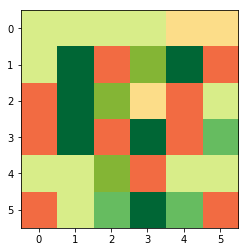

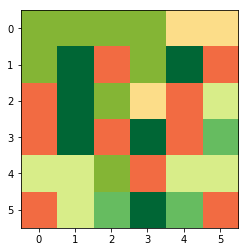

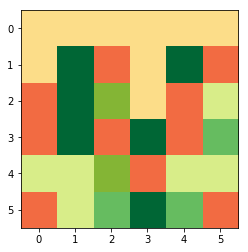

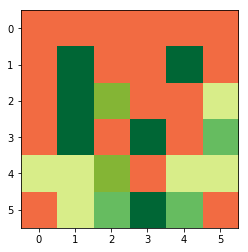

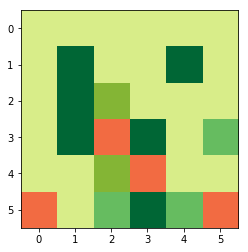

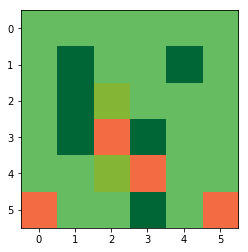

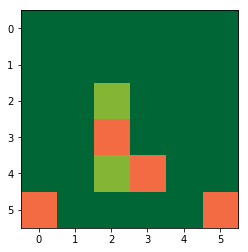

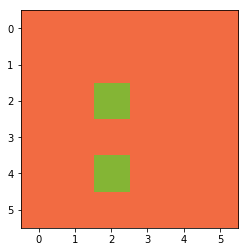

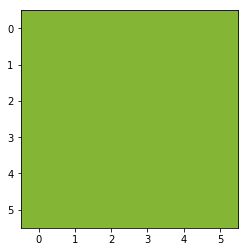

The initial game board was:


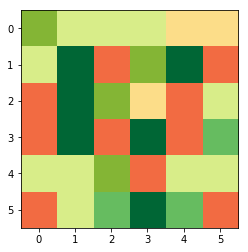

With hiuristic type 0, 10 steps were needed to solve the game
Total time taken to solve was 0.21431446075439453 seconds
Total number of state visited is 31


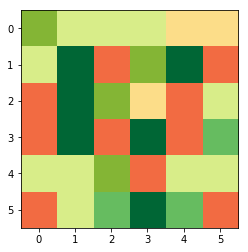

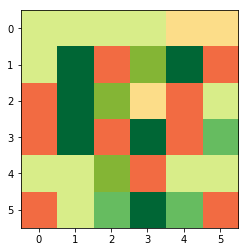

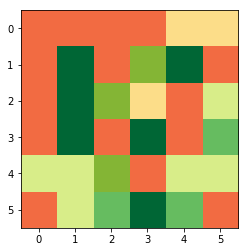

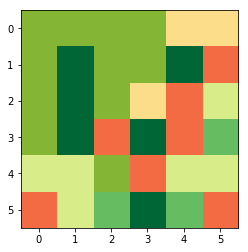

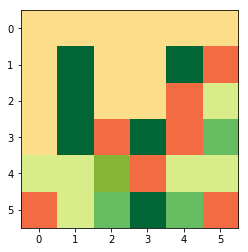

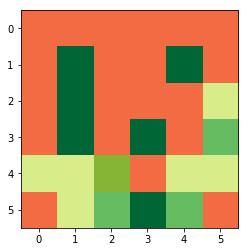

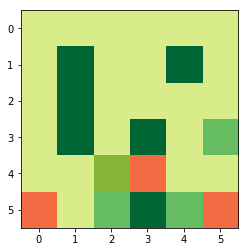

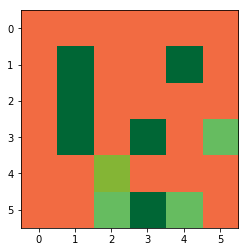

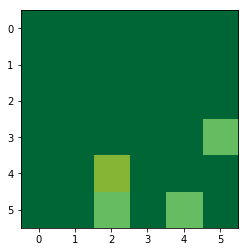

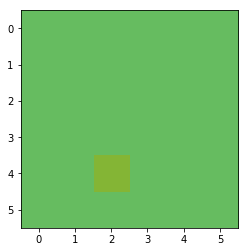

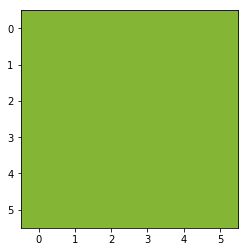

The initial game board was:


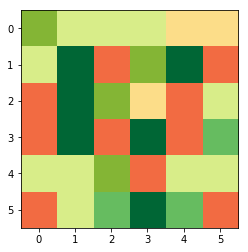

With hiuristic type 1, 13 steps were needed to solve the game
Total time taken to solve was 0.19579386711120605 seconds
Total number of state visited is 42


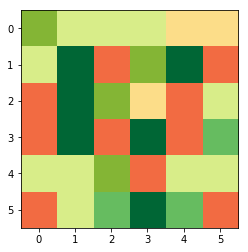

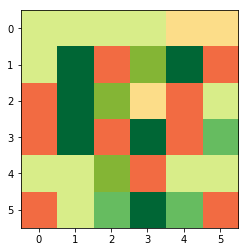

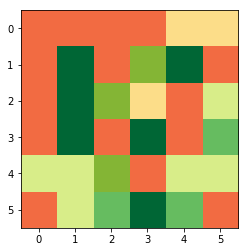

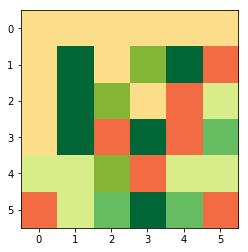

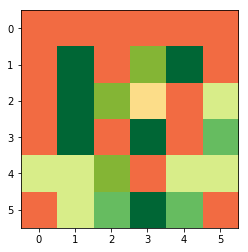

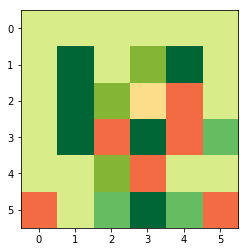

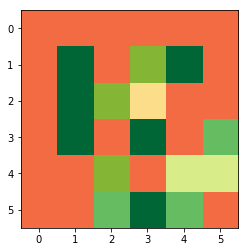

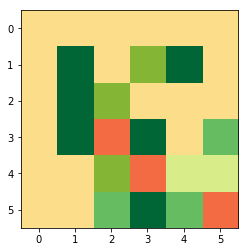

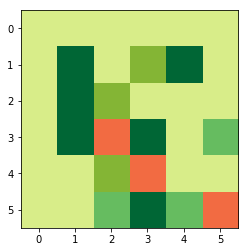

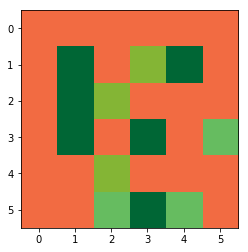

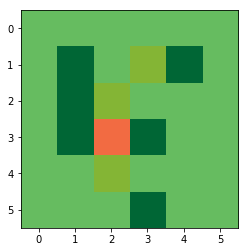

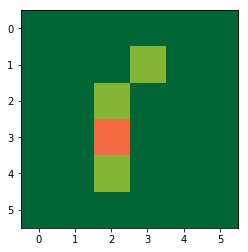

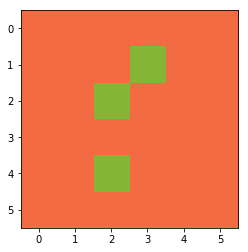

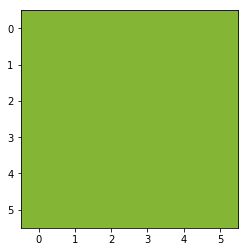

In [6]:
board = np.random.randint(6, size=(6,6))
st = state(board, 0)

solve_bfs(st)
solve_a_star(st, 0)
solve_a_star(st, 1)

The hiuristic 0 for A* search has given the best result so far. But as this is not an admissible hiuristic function, this gives a suboptimal result. But pretty good suboptimal.

The initial game board was:


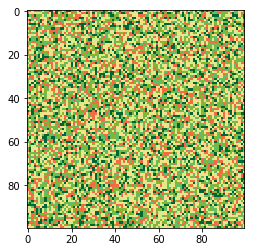

With hiuristic type 0, 217 steps were needed to solve the game
Total time taken to solve was 95.75024390220642 seconds
Total number of state visited is 1076


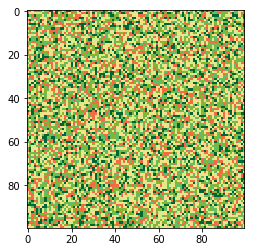

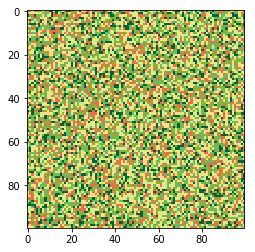

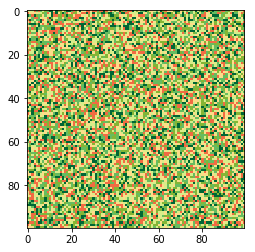

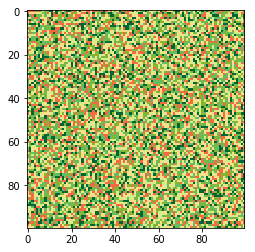

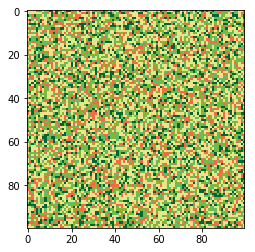

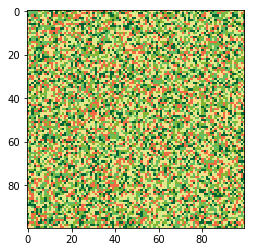

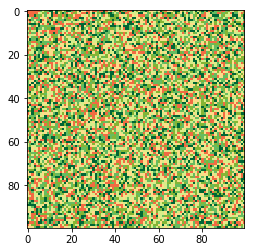

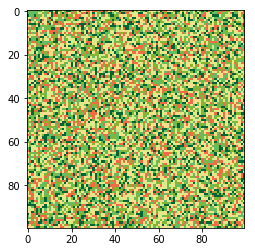

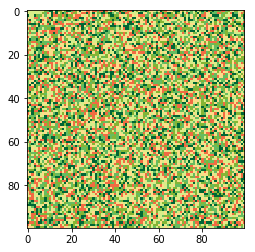

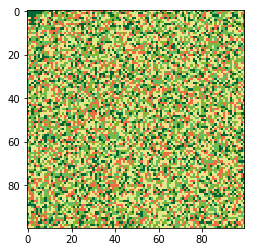

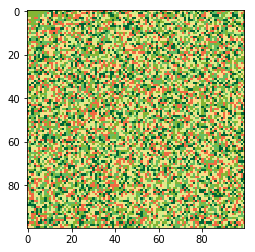

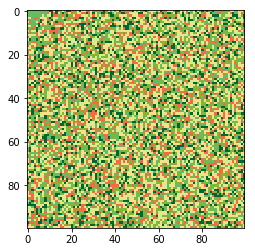

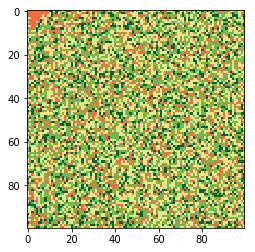

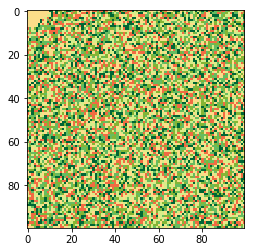

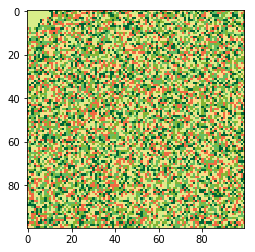

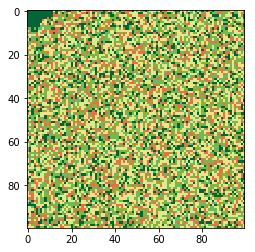

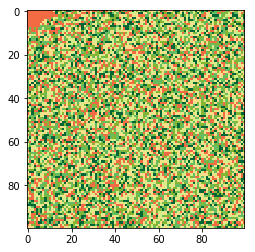

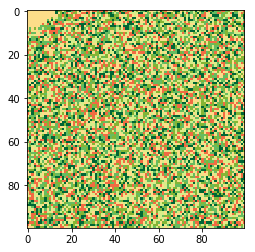

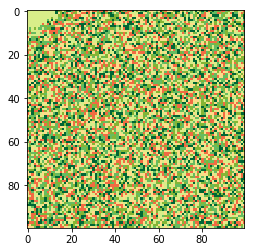

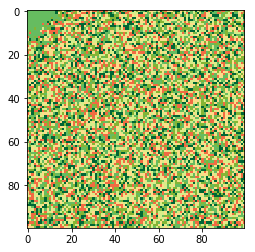

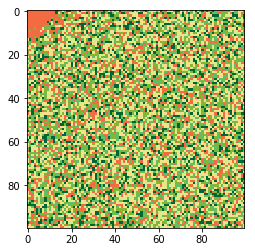

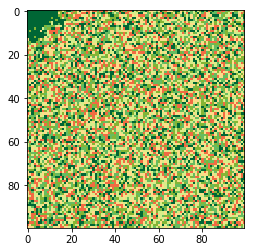

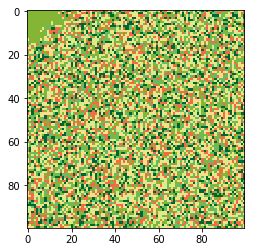

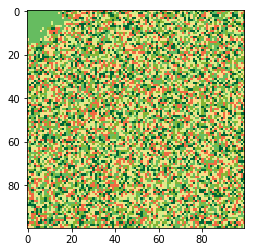

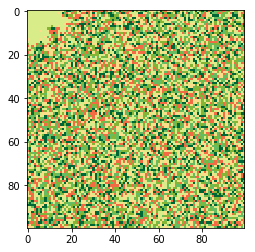

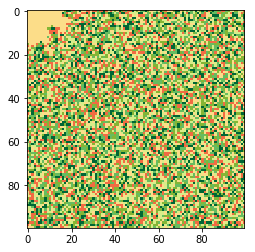

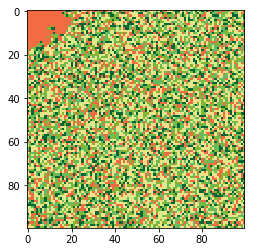

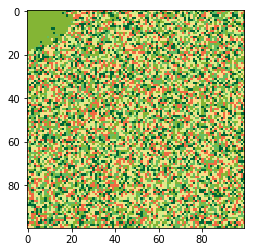

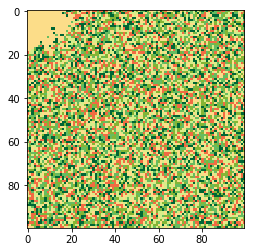

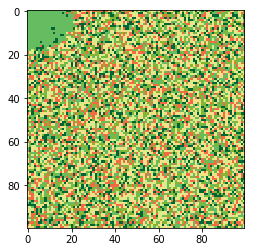

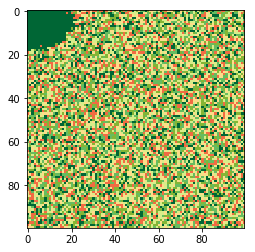

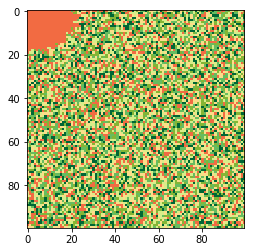

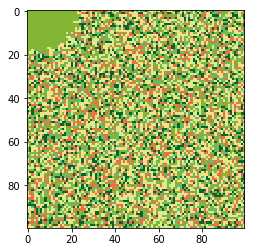

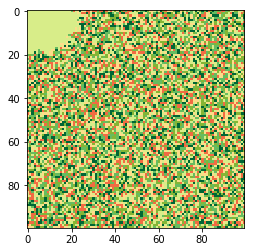

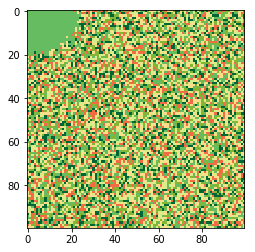

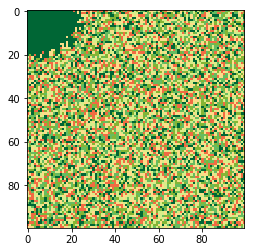

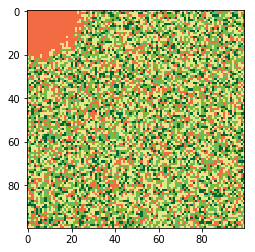

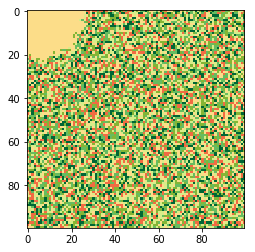

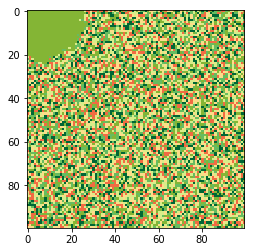

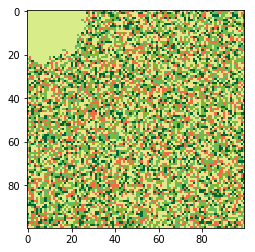

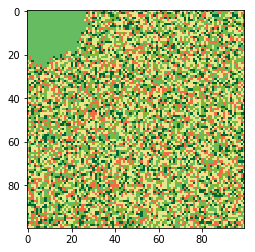

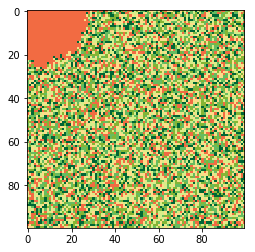

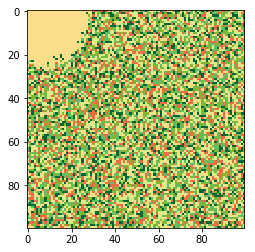

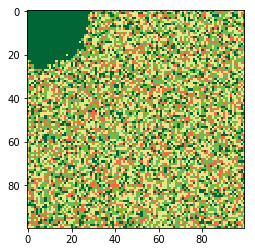

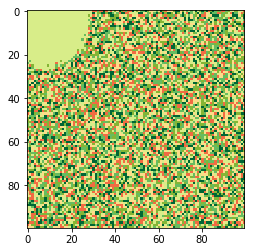

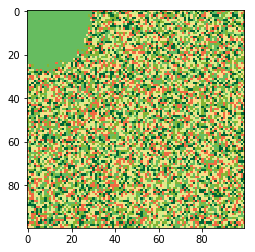

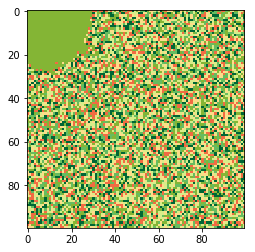

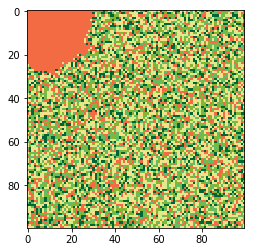

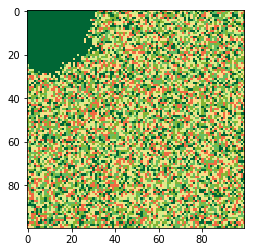

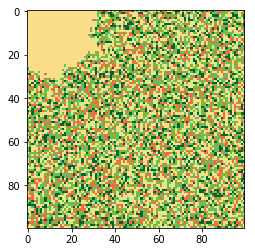

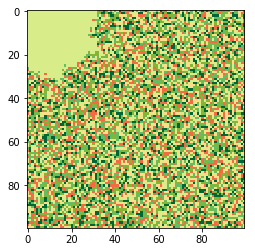

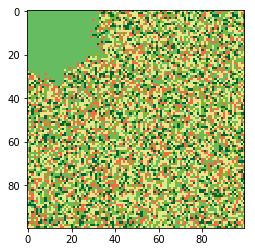

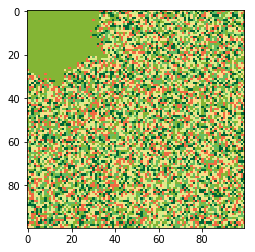

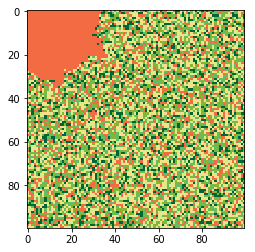

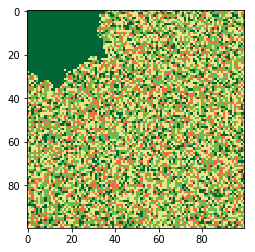

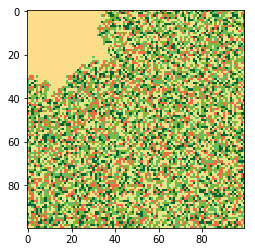

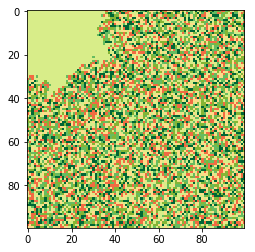

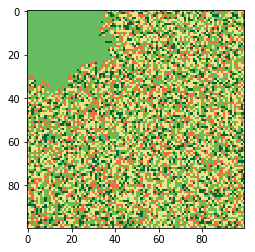

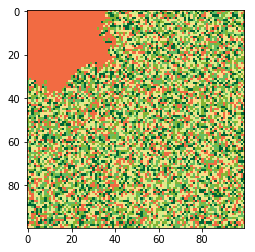

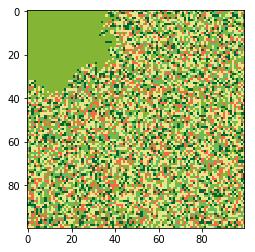

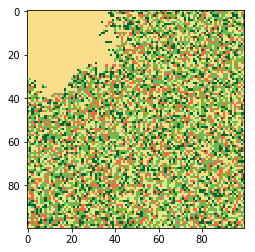

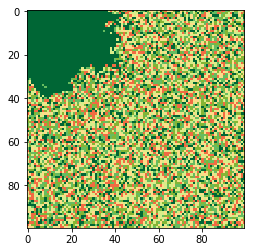

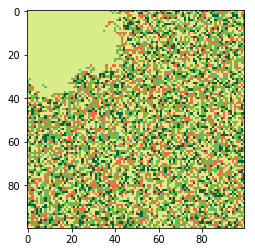

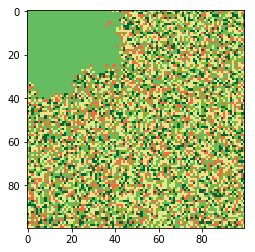

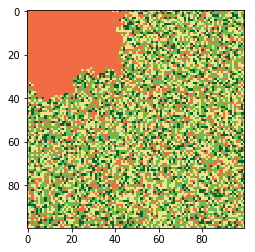

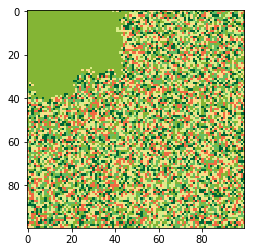

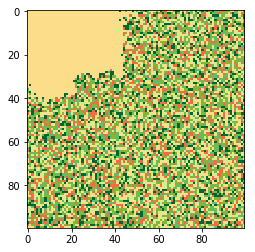

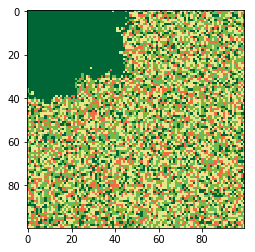

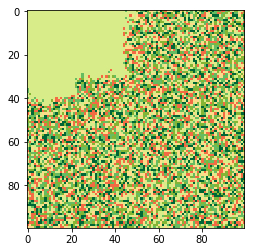

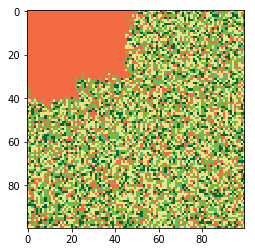

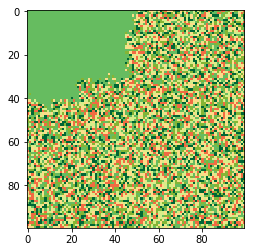

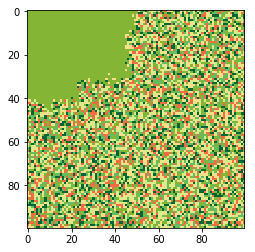

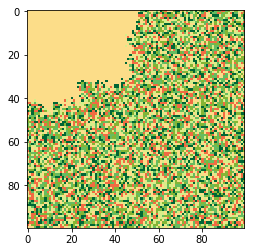

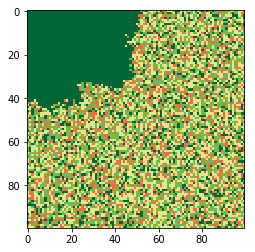

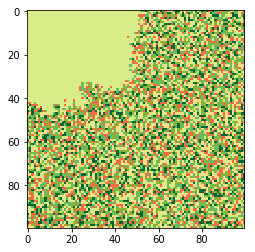

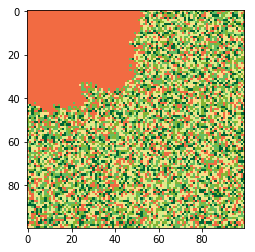

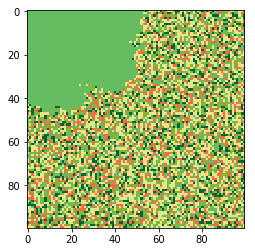

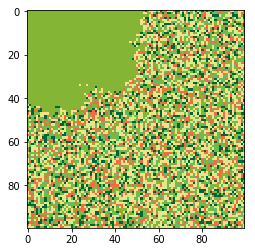

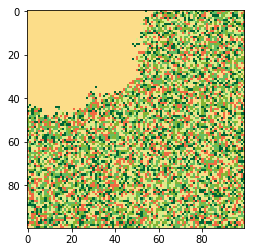

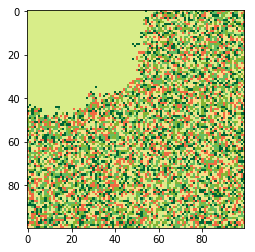

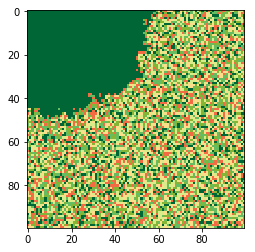

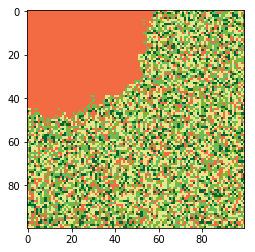

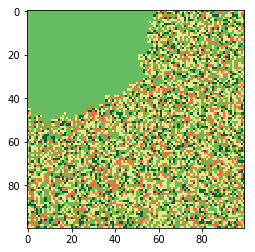

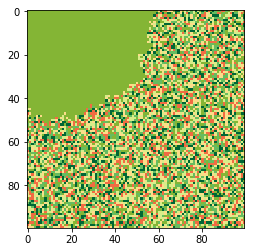

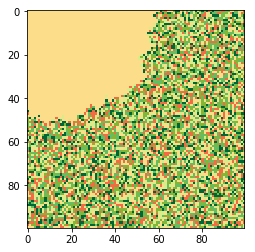

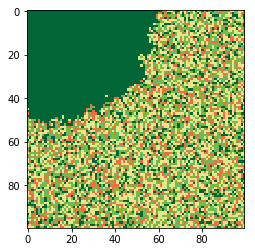

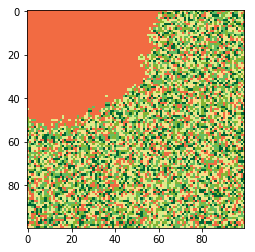

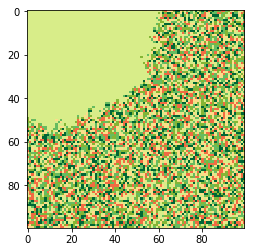

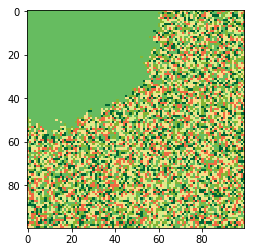

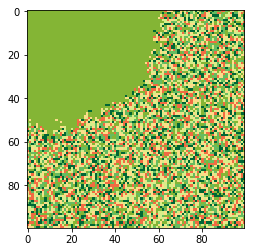

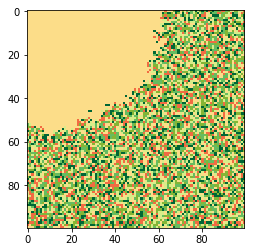

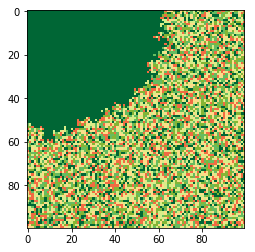

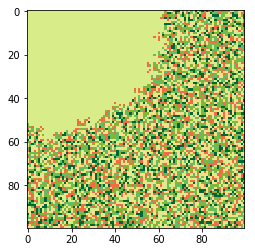

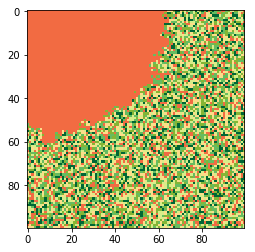

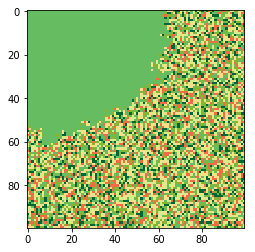

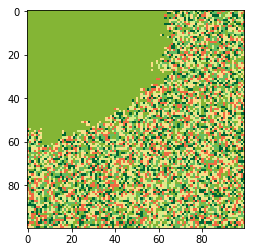

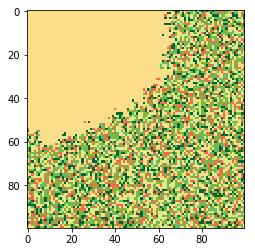

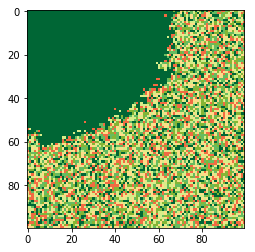

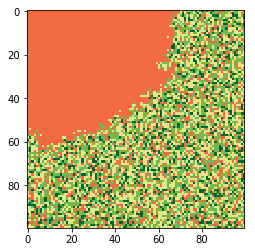

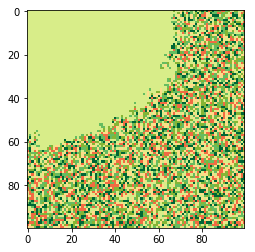

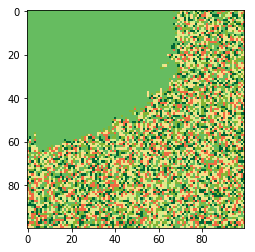

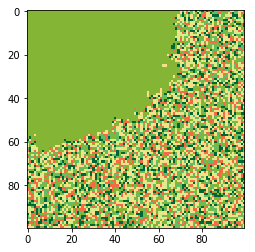

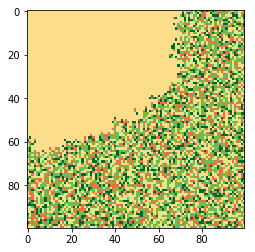

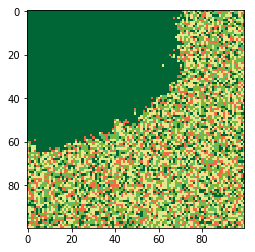

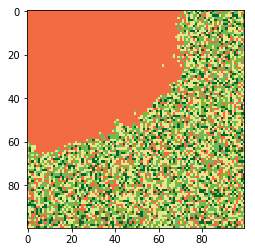

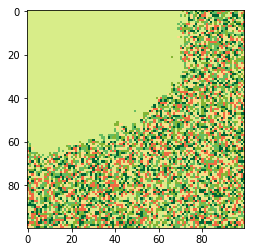

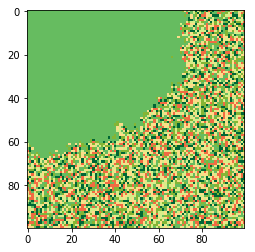

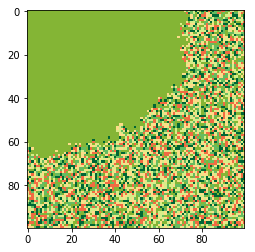

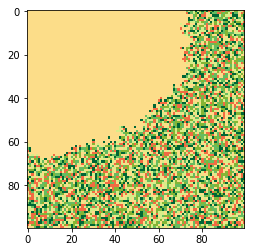

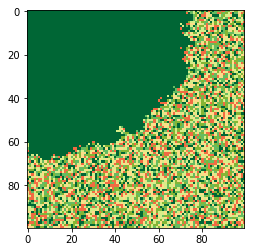

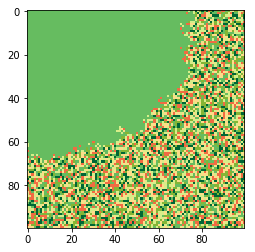

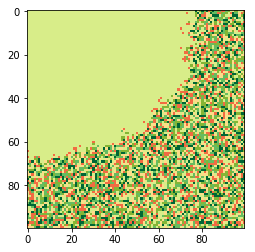

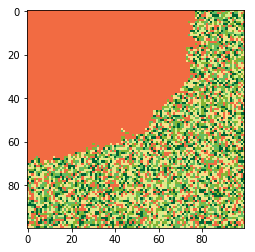

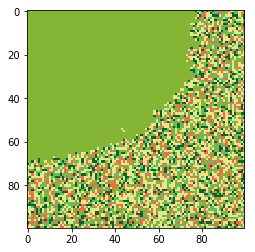

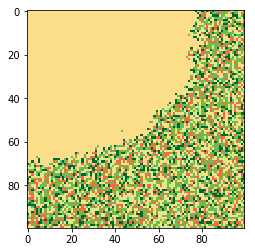

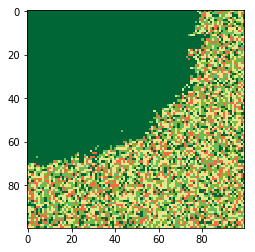

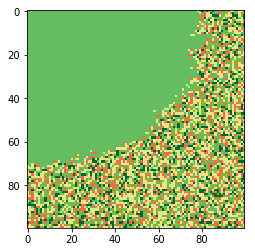

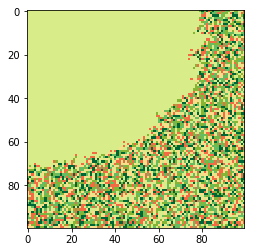

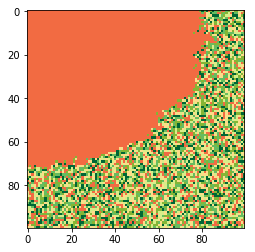

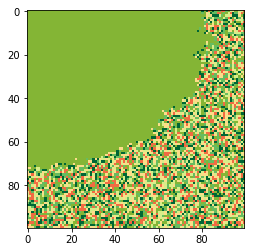

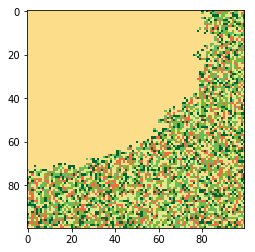

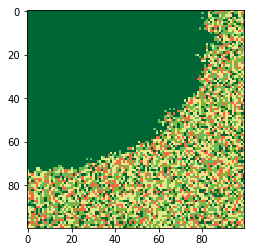

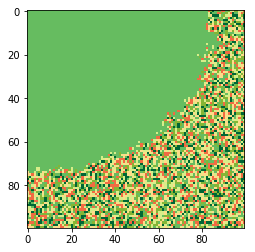

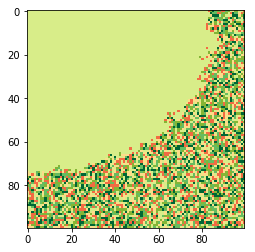

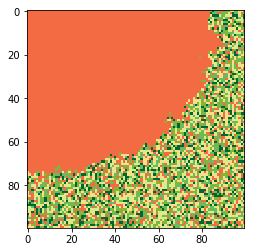

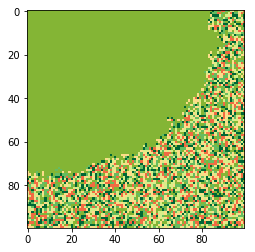

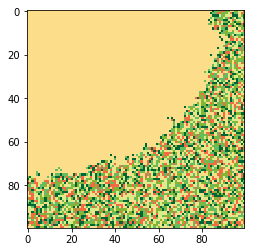

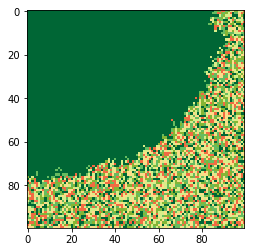

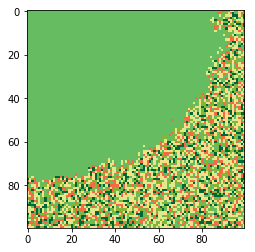

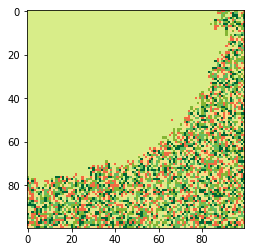

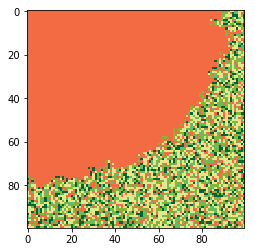

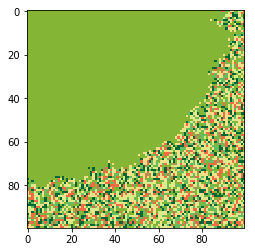

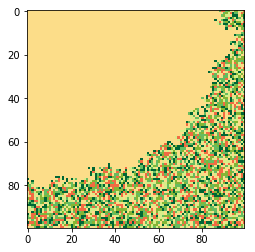

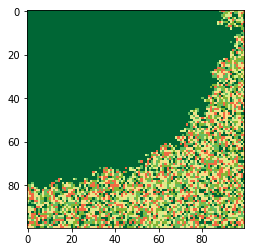

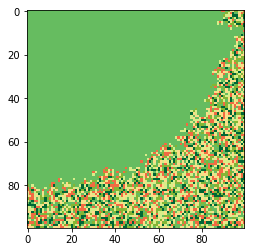

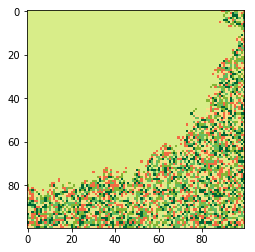

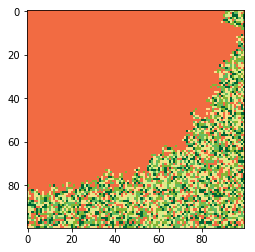

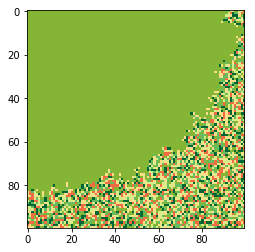

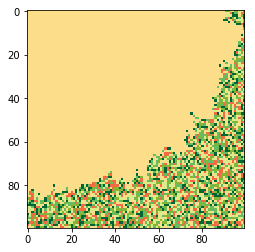

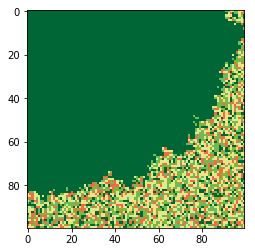

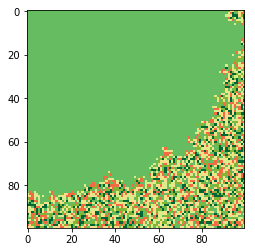

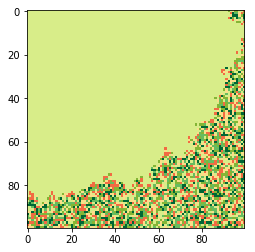

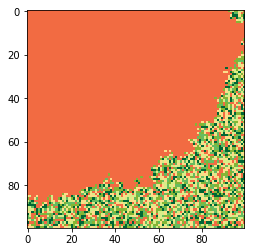

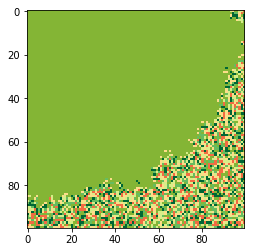

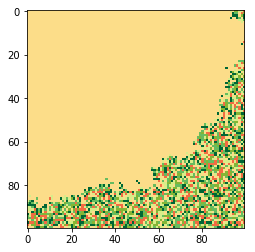

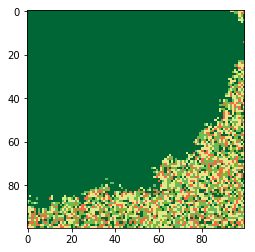

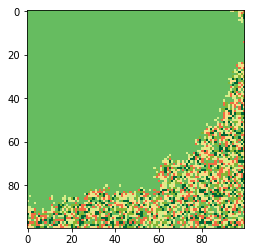

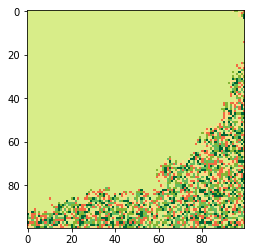

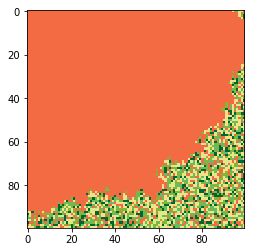

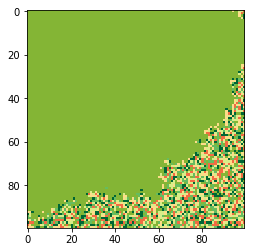

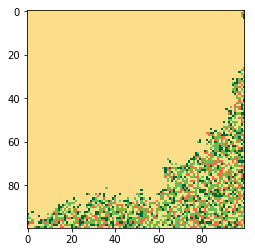

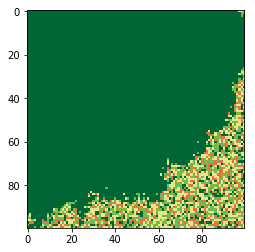

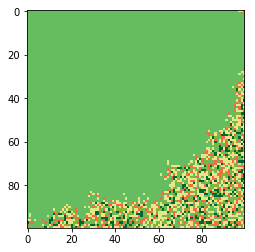

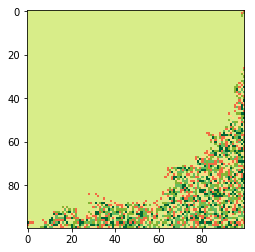

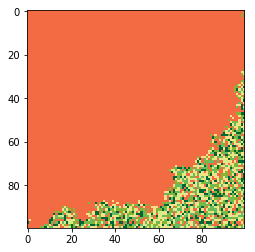

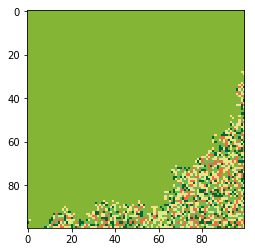

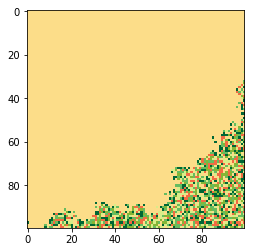

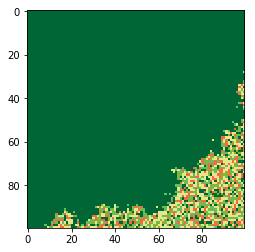

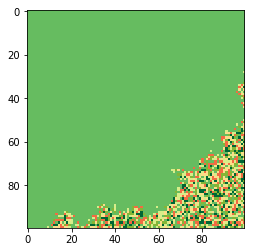

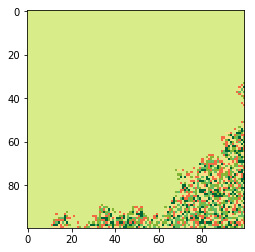

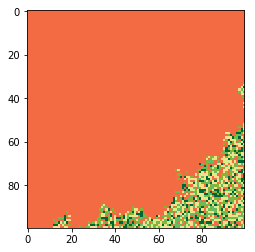

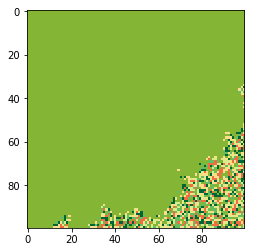

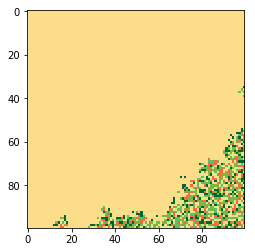

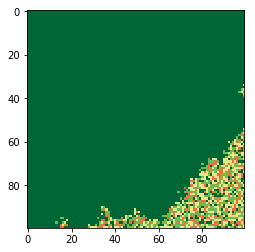

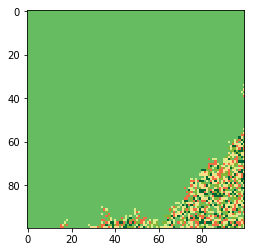

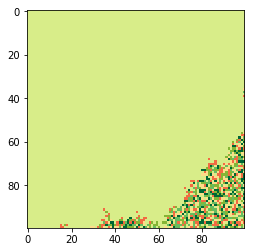

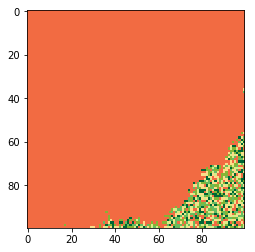

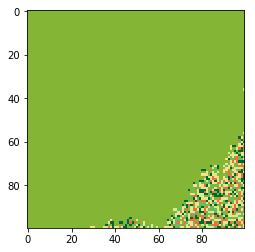

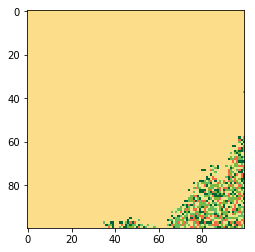

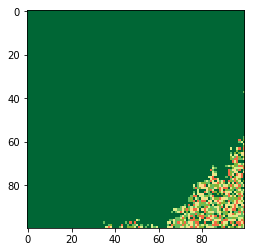

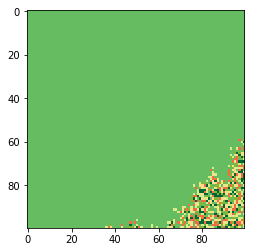

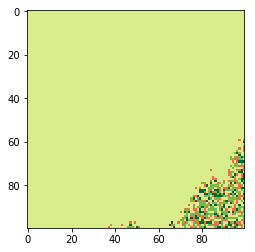

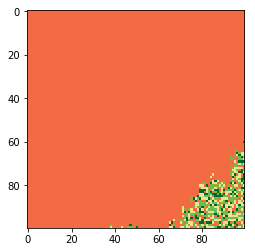

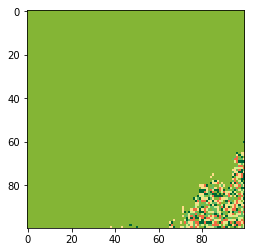

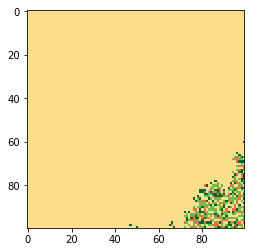

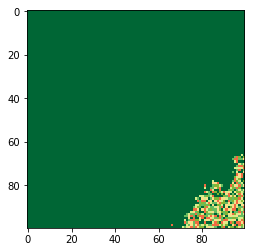

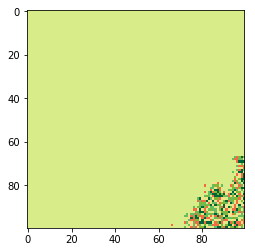

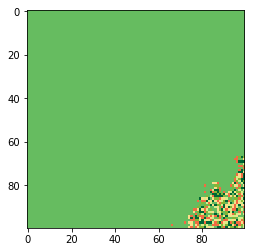

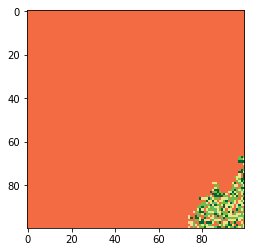

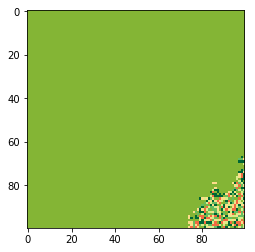

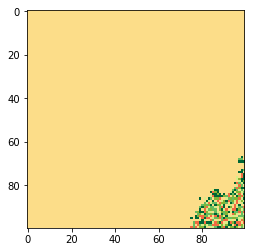

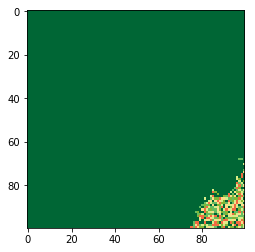

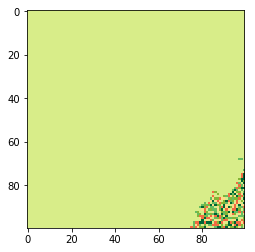

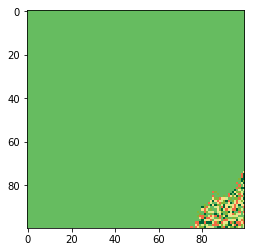

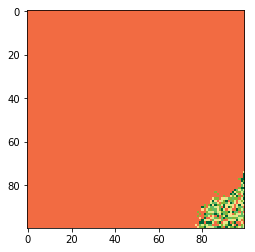

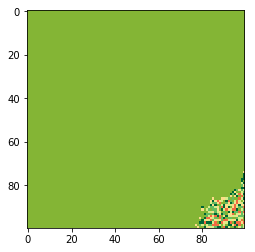

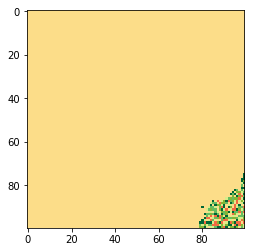

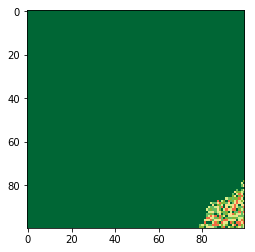

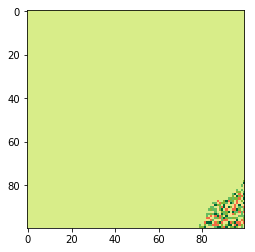

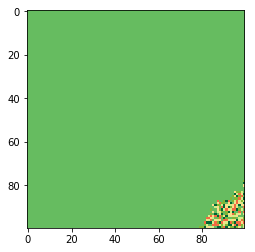

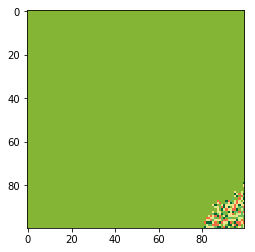

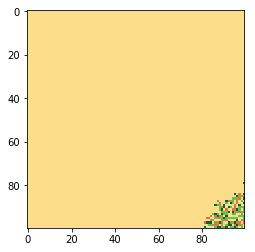

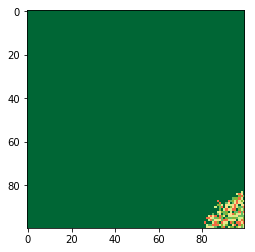

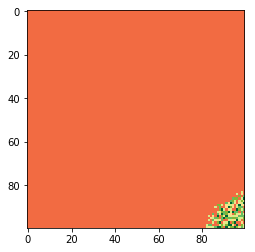

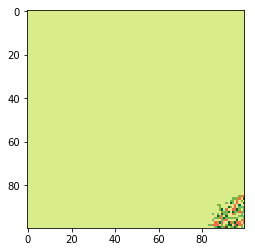

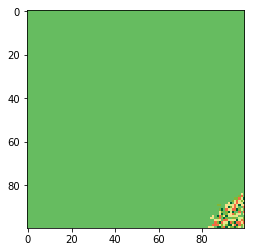

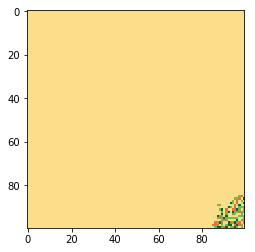

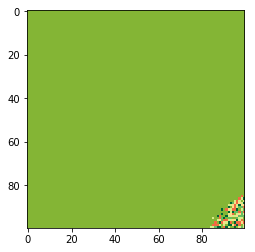

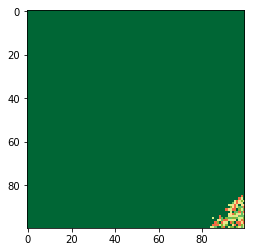

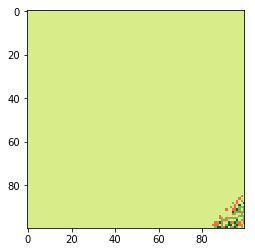

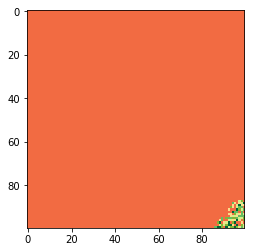

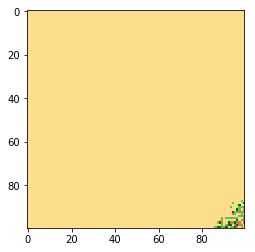

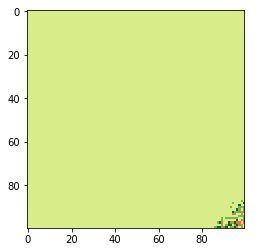

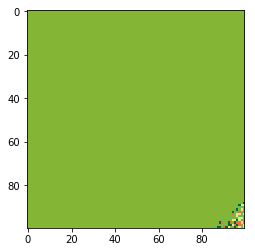

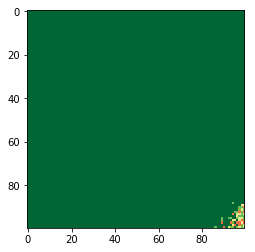

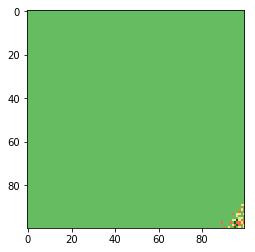

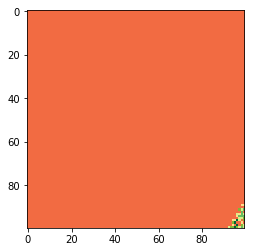

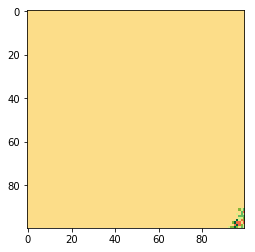

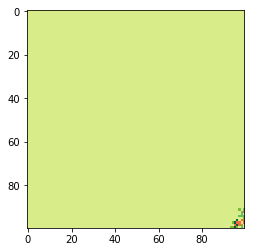

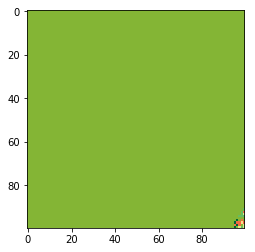

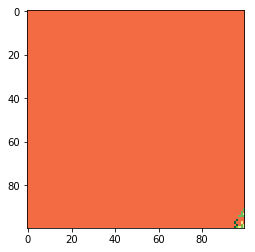

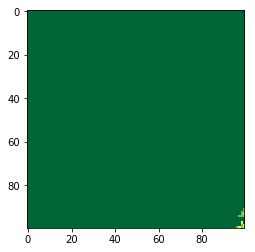

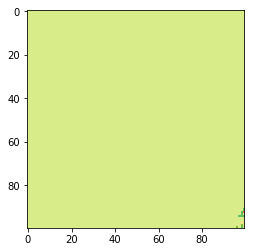

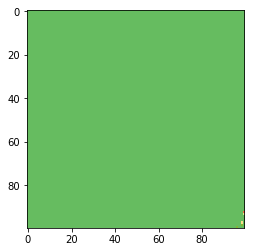

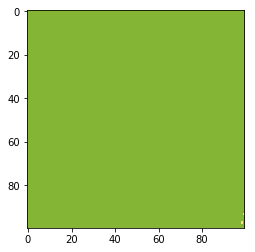

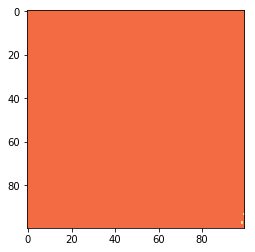

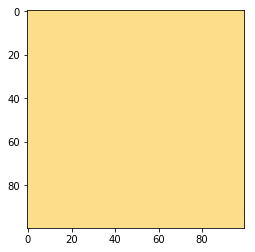

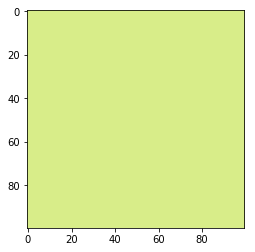

In [7]:
board = np.random.randint(6, size=(100,100))
st = state(board, 0)

solve_a_star(st, 0)